In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
import sys
from pycocotools.coco import COCO
import urllib
import zipfile 

In [3]:
os.makedirs('opt' , exist_ok=True)
os.chdir( '/content/opt' )
!git clone 'https://github.com/cocodataset/cocoapi.git'

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 19.00 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [4]:
os.chdir('/content/opt/cocoapi')

# Download the annotation : 
annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
#image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'

urllib.request.urlretrieve(annotations_trainval2014 , filename = 'annotations_trainval2014.zip' )
#urllib.request.urlretrieve(image_info_test2014 , filename= 'image_info_test2014.zip' )

('annotations_trainval2014.zip', <http.client.HTTPMessage at 0x7fc2717857e0>)

In [5]:
with zipfile.ZipFile('annotations_trainval2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )  

try:
  os.remove( 'annotations_trainval2014.zip' )
  print('zip removed')
except:
  None

zip removed


In [6]:
os.chdir('/content/opt/cocoapi/annotations')
# initialize COCO API for instance annotations
dataType = 'val2014'
instances_annFile = 'instances_{}.json'.format(dataType)
print(instances_annFile)
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = 'captions_{}.json'.format(dataType)
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

instances_val2014.json
loading annotations into memory...
Done (t=5.45s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


In [7]:
import matplotlib.pyplot as plt 
import skimage.io as io 
import numpy as np 
%matplotlib inline 

http://images.cocodataset.org/val2014/COCO_val2014_000000523373.jpg
Number of annotations i.e captions for the image:  [105888, 106923, 138723, 158982, 158985]

A table full of vegetables and fruits  piled on top of each other.
Group of mixed vegetables sitting on a counter top in a kitchen. 
Close-up of fruits and vegetables on a table.
There is a pile of fruit and vegetables on a table
Assorted  fruits and vegetables displayed in a kitchen scene.


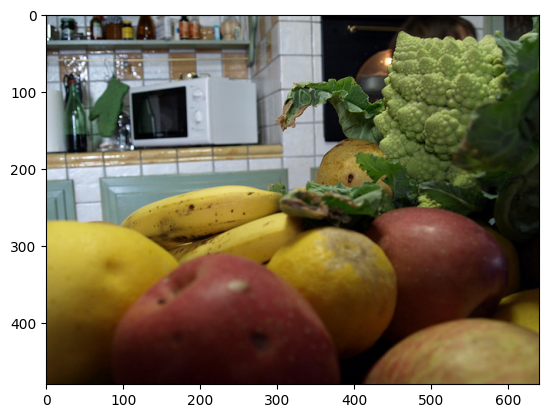

In [8]:
#Pick a random annotation id and display img of that annotation  :
ann_id = np.random.choice( ids )
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs( img_id )[0]
url = img['coco_url']
print(url)
I = io.imread(url)
plt.imshow(I)

# Display captions for that annotation id :
ann_ids = coco_caps.getAnnIds( img_id   )
print('Number of annotations i.e captions for the image: ' , ann_ids)
print()
anns = coco_caps.loadAnns( ann_ids )
coco_caps.showAnns(anns)

In [9]:
os.chdir('/content/opt/cocoapi')

train2014 = 'http://images.cocodataset.org/zips/train2014.zip'
test2014 = 'http://images.cocodataset.org/zips/test2014.zip'
val2014 = 'http://images.cocodataset.org/zips/val2014.zip'

urllib.request.urlretrieve( train2014 , 'train2014' )
#urllib.request.urlretrieve( test2014 , 'test2014' )
urllib.request.urlretrieve( val2014 , 'val2014' )

('val2014', <http.client.HTTPMessage at 0x7fc2045c4790>)

In [10]:
os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'train2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'train2014' )
  print('zip removed')
except:
  None


os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'val2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'val2014' )
  print('zip removed')
except:
  None

zip removed
zip removed


In [11]:
import nltk
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='../cocoapi/annotations/captions_train2014.json',
        vocab_from_file=False):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [12]:
import nltk
import os
import torch
import torch.utils.data as data
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import random
import json

def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/opt'):
   
    
    assert mode in ['train', 'val'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/train2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2014.json')
    if mode == 'val':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/val2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_val2014.json')
    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':            
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

In [13]:
import sys
from pycocotools.coco import COCO
!pip install nltk
import nltk
nltk.download('punkt')
from torchvision import transforms


# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 8

# Specify the batch size.
batch_size = 32

# Obtain the data loader.
data_loader_train = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         cocoapi_loc = '/content/opt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


loading annotations into memory...
Done (t=0.87s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:37<00:00, 11021.87it/s]


In [14]:
import torch 
import numpy as np 
import torch.utils.data as data

In [15]:
sample_caption = 'A person doing a trick xxxx on a rail while riding a skateboard.'
sample_tokens = nltk.tokenize.word_tokenize( sample_caption.lower() )

sample_caption = []
start_word  = data_loader_train.dataset.vocab.start_word
end_word = data_loader_train.dataset.vocab.end_word
sample_tokens.insert(0 , start_word)
sample_tokens.append(end_word)
sample_caption.extend( [ data_loader_train.dataset.vocab(token) for token in sample_tokens ] )


sample_caption = torch.Tensor( sample_caption ).long()
print('Find Below the Sample tokens and the idx values of those tokens in word2idx' , '\n')
print(sample_tokens) 
print(sample_caption )

print('Find index values for words below \n')
print('Start idx {} , End idx {} , unknown idx {}'.format( 0,1,2 ))

Find Below the Sample tokens and the idx values of those tokens in word2idx 

['<start>', 'a', 'person', 'doing', 'a', 'trick', 'xxxx', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.', '<end>']
tensor([  0,   3,  97, 744,   3, 393,   2,  38,   3, 993, 205, 137,   3, 743,
         18,   1])
Find index values for words below 

Start idx 0 , End idx 1 , unknown idx 2


In [16]:
# Lets check word2idx in vocb 
print('First few vocab' , dict(list(data_loader_train.dataset.vocab.word2idx.items())[:10]))
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader_train.dataset.vocab))

First few vocab {'<start>': 0, '<end>': 1, '<unk>': 2, 'a': 3, 'very': 4, 'clean': 5, 'and': 6, 'well': 7, 'decorated': 8, 'empty': 9}
Total number of tokens in vocabulary: 7072


In [17]:
from collections import Counter

counter = Counter(data_loader_train.dataset.caption_lengths)
lengths = sorted( counter.items() , key = lambda pair : pair[1] , reverse=True )
for val,count in lengths:
  print( 'value %2d  count %5d' %(val,count) )
  if count < 10000: 
    break

value 10  count 86302
value 11  count 79971
value  9  count 71920
value 12  count 57653
value 13  count 37668
value 14  count 22342
value  8  count 20742
value 15  count 12839
value 16  count  7736


In [18]:
# Randomly sample a caption length, and sample indices with that length.
indices = data_loader_train.dataset.get_train_indices()
print('Sample Indices:' , indices )

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
sampler = data.sampler.SubsetRandomSampler(  indices )
data_loader_train.batch_sampler.sampler = sampler 

# obtain images, caption :
images , captions = next(iter(data_loader_train))
print(images.shape , captions.shape)

Sample Indices: [95116, 400037, 185817, 367884, 132078, 36273, 51615, 106648, 307640, 285383, 18300, 193974, 351732, 335940, 173227, 297842, 265589, 50548, 376445, 246211, 193535, 68044, 135697, 299731, 376783, 363190, 366505, 413164, 256013, 60324, 71352, 148823]
torch.Size([32, 3, 224, 224]) torch.Size([32, 16])


# ENCODER CLASS

In [19]:
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)        
        features = features.view(features.size(0), -1)        
        features = self.embed(features)        
        return features

In [20]:
# specify dim of image embedding
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_size = 256 
encoder = EncoderCNN( embed_size )
encoder.to(device)
images=  images.to(device) # images from step2 
features = encoder(images)

print(type(features) , features.shape , images.shape)
assert( type(features) == torch.Tensor )  , 'Encoder output should be pytorch tensor'
assert (features.shape[0] == batch_size) & (features.shape[1] == embed_size) , "The shape of the encoder output is incorrect."

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 75.9MB/s]


<class 'torch.Tensor'> torch.Size([32, 256]) torch.Size([32, 3, 224, 224])


In [21]:
import os 
import torch.utils.data as data 
import torch 
import math
import pickle
import matplotlib.pyplot as plt 
%matplotlib inline

# DECODER CLASS

In [36]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super( DecoderRNN , self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size 
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.word_embedding = nn.Embedding( self.vocab_size , self.embed_size )
        self.gru  = nn.GRU(    input_size  =  self.embed_size , 
                             hidden_size = self.hidden_size,
                             num_layers  = self.num_layers ,
                             batch_first = True 
                             )
        self.fc = nn.Linear( self.hidden_size , self.vocab_size  )
        

    def init_hidden( self, batch_size ):
      return ( torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device) )
    
    def forward(self, features, captions):            
      captions = captions[:,:-1]      
      self.batch_size = features.shape[0]
      self.hidden = self.init_hidden( self.batch_size )
      embeds = self.word_embedding( captions )
      inputs = torch.cat( ( features.unsqueeze(dim=1) , embeds ) , dim =1  )      
      gru_out , self.hidden = self.gru(inputs , self.hidden)      
      outputs = self.fc( gru_out )      
      return outputs

    def Predict(self, inputs, max_len=20):        
        final_output = []
        batch_size = inputs.shape[0]         
        hidden = self.init_hidden(batch_size) 
    
        while True:
            gru_out, hidden = self.gru(inputs, hidden) 
            outputs = self.fc(gru_out)  
            outputs = outputs.squeeze(1) 
            _, max_idx = torch.max(outputs, dim=1) 
            final_output.append(max_idx.cpu().numpy()[0].item())             
            if (max_idx == 1 or len(final_output) >=20 ):
                break
            
            inputs = self.word_embedding(max_idx) 
            inputs = inputs.unsqueeze(1)             
        return final_output  

In [37]:
embed_size = 256
hidden_size = 100
num_layers =1 
num_epochs = 1
print_every = 200
save_every = 1 
vocab_size = len(data_loader_train.dataset.vocab)
total_step = math.ceil( len(data_loader_train.dataset.caption_lengths) / data_loader_train.batch_sampler.batch_size   )


decoder = DecoderRNN(  embed_size , hidden_size, vocab_size ,num_layers)
criterion = nn.CrossEntropyLoss()
lr = 0.001
all_params = list(decoder.parameters())  + list( encoder.embed.parameters() )
optimizer = torch.optim.Adam( params  = all_params , lr = lr  )



device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save_path = '/content/drive/My Drive/MSCOCO_SAVED_VAL_FILES/checkpoint'
os.makedirs( model_save_path , exist_ok=True)

# Save the params needed to created the model :
decoder_input_params = {'embed_size' : embed_size , 
                'hidden_size' : hidden_size , 
                'num_layers' : num_layers,
                'lr' : lr ,
                'vocab_size' : vocab_size
                }

with open(  os.path.join(model_save_path , 'decoder_input_params.pickle'), 'wb') as handle:
    pickle.dump(decoder_input_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
import sys 
for e in range(num_epochs):
  for step in range(total_step):
    indices = data_loader_train.dataset.get_train_indices()
    new_sampler = data.sampler.SubsetRandomSampler( indices )
    data_loader_train.batch_sampler.sampler = new_sampler    
    images,captions = next(iter(data_loader_train))    
    images , captions = images.to(device) , captions.to(device)
    encoder , decoder = encoder.to(device) , decoder.to(device)
    encoder.zero_grad()    
    decoder.zero_grad()
    features = encoder(images)
    output = decoder( features , captions )    
    loss = criterion( output.view(-1, vocab_size) , captions.view(-1) )
    loss.backward()
    optimizer.step()
    stat_vals = 'Epochs [%d/%d] Step [%d/%d] Loss [%.4f] ' %( e+1,num_epochs,step,total_step,loss.item() )
    if step % print_every == 0 :
      print(stat_vals)
      sys.stdout.flush()
    if e % save_every == 0:
      torch.save( encoder.state_dict() ,  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(e+1) ) )
      torch.save( decoder.state_dict() ,  os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(e+1) ) )

Epochs [1/1] Step [0/12942] Loss [8.8669] 
Epochs [1/1] Step [200/12942] Loss [3.9361] 
Epochs [1/1] Step [400/12942] Loss [4.3628] 
Epochs [1/1] Step [600/12942] Loss [3.5937] 
Epochs [1/1] Step [800/12942] Loss [3.5872] 
Epochs [1/1] Step [1000/12942] Loss [3.0234] 
Epochs [1/1] Step [1200/12942] Loss [3.1202] 
Epochs [1/1] Step [1400/12942] Loss [2.9819] 
Epochs [1/1] Step [1600/12942] Loss [2.8675] 
Epochs [1/1] Step [1800/12942] Loss [3.2307] 
Epochs [1/1] Step [2000/12942] Loss [3.8355] 
Epochs [1/1] Step [2200/12942] Loss [2.7680] 
Epochs [1/1] Step [2400/12942] Loss [3.0852] 
Epochs [1/1] Step [2600/12942] Loss [2.8183] 
Epochs [1/1] Step [2800/12942] Loss [2.9222] 
Epochs [1/1] Step [3000/12942] Loss [2.9279] 
Epochs [1/1] Step [3200/12942] Loss [3.0516] 
Epochs [1/1] Step [3400/12942] Loss [2.4138] 
Epochs [1/1] Step [3600/12942] Loss [3.4351] 
Epochs [1/1] Step [3800/12942] Loss [2.9872] 
Epochs [1/1] Step [4000/12942] Loss [2.9246] 
Epochs [1/1] Step [4200/12942] Loss [2.72

In [40]:
model_save_path = '/content/drive/MyDrive/MSCOCO_SAVED_VAL_FILES/checkpoint'
os.makedirs( model_save_path , exist_ok=True)

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(os.path.join(model_save_path , 'decoder_input_params.pickle'), 'rb') as handle:
    decoder_input_params = pickle.load(handle)

embed_size = decoder_input_params['embed_size']
hidden_size= decoder_input_params['hidden_size']
vocab_size = decoder_input_params['vocab_size']
num_layers = decoder_input_params['num_layers']

encoder = EncoderCNN( embed_size )
encoder.load_state_dict(   torch.load(  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(1) )   ) )

decoder = DecoderRNN( embed_size , hidden_size , vocab_size , num_layers )
decoder.load_state_dict( torch.load(   os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(1) )   ) )

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [41]:
from torchvision import transforms

# Define a transform to pre-process the training images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#Obtain the data loader.
data_loader_val = get_loader(transform=transform_test,
                         mode='val',                         
                         cocoapi_loc = '/content/opt')

data_iter = iter(data_loader_val)

Vocabulary successfully loaded from vocab.pkl file!


If you use test_data instead of val_data, then use the simple method:



```
data_loader_test = get_loader(transform=transform_test,
                         mode='test',                         
                         cocoapi_loc = '/content/opt')

data_iter = iter(data_loader_test)

encoder.to(device) 
decoder.to(device)
encoder.eval()
decoder.eval()
original_img , processed_img  = next( data_iter )

def get_sentences( original_img, all_predictions ):
  sentence = ' '
  plt.imshow(original_img.squeeze())
  return sentence.join([data_loader_val.dataset.vocab.idx2word[idx] for idx in all_predictions[1:-1] ]  )

features  = encoder(processed_img.to(device)   ).unsqueeze(1)
outputs = decoder.Predict( features  , max_len=20)
get_sentences(original_img,outputs)


```



In [42]:
vocab = Vocabulary(vocab_threshold=8,vocab_from_file = True)
vocab.get_vocab()

Vocabulary successfully loaded from vocab.pkl file!
Vocabulary successfully loaded from vocab.pkl file!


In [43]:
import random

In [47]:
annotations_file = '/content/opt/cocoapi/annotations/captions_val2014.json'
def testing():
  coco_val = COCO(annotations_file)
  id = list(coco_val.anns.keys())
  # index = random.choice(id)
  ann_id = random.choice(id)
  caption = coco_val.anns[ann_id]['caption']
  print("image_caption : \t" , caption)
  img_id = coco_val.anns[ann_id]['image_id']
  path = coco_val.loadImgs(img_id)[0]['file_name']
  image = Image.open(os.path.join('/content/opt/cocoapi/images/val2014', path)).convert('RGB')
  image = transform_train(image)
  encoder.to(device) 
  decoder.to(device)
  encoder.eval()
  decoder.eval()
  features  = encoder(image.unsqueeze(0).to(device)   ).unsqueeze(1)
  outputs = decoder.Predict( features  , max_len=20)
  caps = [vocab.idx2word[idx] for idx in outputs[1:-1]]
  return bleu_score(caption,caps)
  
  # transform_train = transforms.Compose([ 
  #     transforms.Resize(256),                          # smaller edge of image resized to 256
  #     transforms.RandomCrop(224),                      # get 224x224 crop from random location
  #     transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
  #     transforms.ToTensor(),                           # convert the PIL Image to a tensor
  #     transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
  #                          (0.229, 0.224, 0.225))])

In [45]:
from nltk.translate.bleu_score import SmoothingFunction,sentence_bleu

smoothie = SmoothingFunction().method4
def bleu_score(original_captions, generated_caption):
  #generated_caption.remove('<start>')
  #generated_caption.remove('<end>')
  print('BLEU Scores :')
  print('A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.')
  b_1 = sentence_bleu(original_captions, generated_caption, weights=(1.0, 0, 0, 0))
  b_2 = sentence_bleu(original_captions, generated_caption, weights=(0.5, 0.5, 0, 0))
  b_3 = sentence_bleu(original_captions, generated_caption, weights=(0.3, 0.3, 0.3, 0), smoothing_function  = smoothie)
  b_4 = sentence_bleu(original_captions, generated_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function = smoothie)

  print("\ngenerated-caption : \t" , ' '.join(generated_caption))

  print('BLEU-1: %f' % b_1)
  print('BLEU-2: %f' % b_2)
  print('BLEU-3: %f' % b_3)
  print('BLEU-4: %f' % b_4)

  return b_1, b_2, b_3, b_4

In [50]:
import time
b_1 = []
b_2 = []
b_3 = []
b_4 = []
for i in range(10):
  print('\n**NEW_INPUT**\n')
  print('\n')
  _1, _2, _3, _4 = testing()
  b_1.append(_1)
  b_2.append(_2)
  b_3.append(_3)
  b_4.append(_4)
  time.sleep(20)


**NEW_INPUT**



loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
image_caption : 	 A couple of airplanes parked stationary on a lot.
BLEU Scores :
A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

generated-caption : 	 a plane flying in the air over a body of water .
BLEU-1: 0.166667
BLEU-2: 0.000000
BLEU-3: 0.050236
BLEU-4: 0.023838


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


**NEW_INPUT**



loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
image_caption : 	 A man holding a white puppy and a red leash.
BLEU Scores :
A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

generated-caption : 	 a dog is laying on a bed in a room .
BLEU-1: 0.181818
BLEU-2: 0.000000
BLEU-3: 0.053605
BLEU-4: 0.025685

**NEW_INPUT**



loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
image_caption : 	 A street with traffic lights and cat sculptures.
BLEU Scores :
A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

generated-caption : 	 a train is traveling down the tracks .
BLEU-1: 0.250000
BLEU-2: 0.000000
BLEU-3: 0.068056
BLEU-4: 0.034011

**NEW_INPUT**



loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
image_caption : 	 there are many taxi cabs on the road
BLEU Scores :
A perfect match re

In [51]:
from statistics import mean
print('Average_BLEU-1_score_for_the_above_printed_images: %f' % mean(b_1))
print('Average_BLEU-2_score_for_the_above_printed_images: %f' % mean(b_2))
print('Average_BLEU-3_score_for_the_above_printed_images: %f' % mean(b_3))
print('Average_BLEU-4_score_for_the_above_printed_images: %f' % mean(b_4))

Average_BLEU-1_score_for_the_above_printed_images: 0.164134
Average_BLEU-2_score_for_the_above_printed_images: 0.000000
Average_BLEU-3_score_for_the_above_printed_images: 0.051808
Average_BLEU-4_score_for_the_above_printed_images: 0.025072


As can be seen from the above outputs the model is not performing well, as it is only being trained for **1 epoch which takes ~4.5hrs**. 

Due to resource constraints on the colab, it's very difficult to go beyond 1 epoch, however, based on hyperparameters tuning and trying for different combinations of hyperparameters, the possibilty of the model performing well can improve.